In [15]:
from transformers import ViTFeatureExtractor
import requests
from PIL import Image
import os
import pickle
import numpy as np
import torch

np.random.seed(0)
torch.manual_seed(0)

def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict[b'data'], dict[b'labels']

def load_cifar10_data(data_dir):
    # Initialize the arrays
    x_train = np.empty((0, 3072))
    y_train = []

    # Load each batch file
    for i in range(1, 6):
        filename = os.path.join(data_dir, f'data_batch_{i}')
        data, labels = load_cifar10_batch(filename)
        x_train = np.vstack((x_train, data))
        y_train += labels

    # Load the test batch
    x_test, y_test = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))

    # Reshape the data
    x_train = x_train.reshape((50000, 3, 32, 32)).transpose(0, 2, 3, 1)
    x_test = x_test.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

    return (x_train, np.array(y_train)), (x_test, np.array(y_test))


cifar10_dir = '/Users/haydenhenderson/Downloads/cifar-10-batches-py.tar.gz'

    # Load the dataset
(x_train, y_train), (x_test, y_test) = load_cifar10_data(cifar10_dir)
feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")
# url = "https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
# image


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [30]:
pixel_values = feature_extractor(x_test[0], return_tensors="pt").pixel_values

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt

imagenet_mean = np.array(feature_extractor.image_mean)
imagenet_std = np.array(feature_extractor.image_std)

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize(pixel_values, model):
    # forward pass
    outputs = model(pixel_values)
    y = model.unpatchify(outputs.logits)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    
    # visualize the mask
    mask = outputs.mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', pixel_values)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

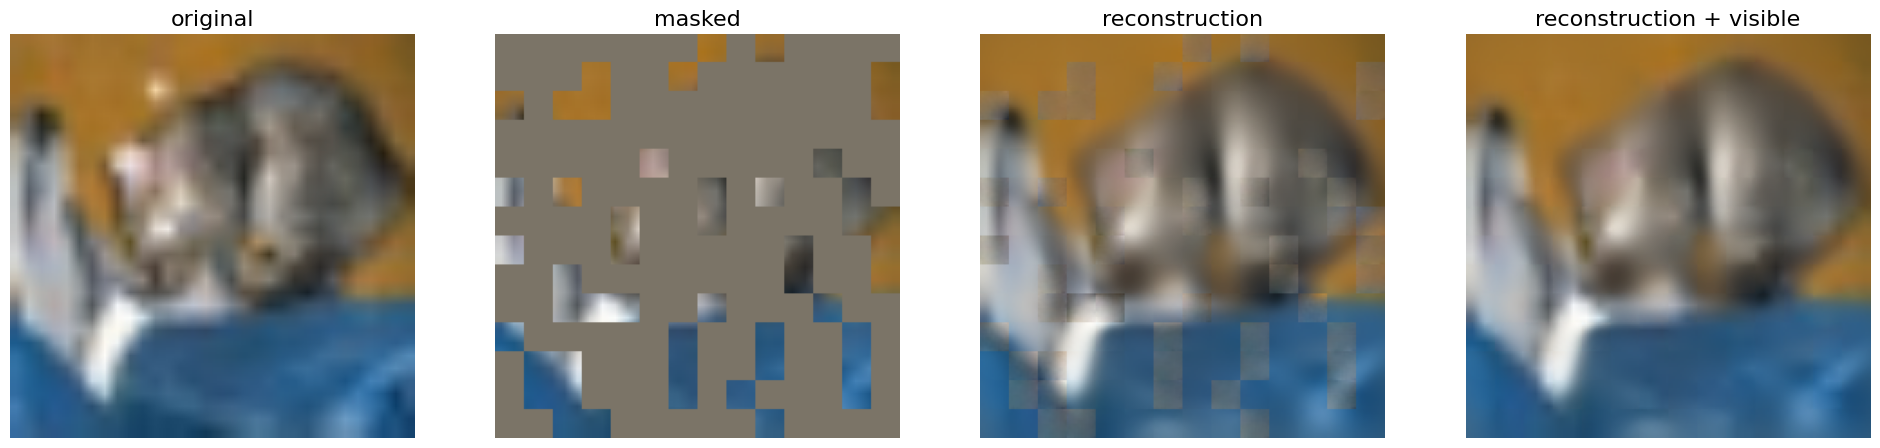

In [32]:
from transformers import ViTMAEForPreTraining

# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)

model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")

visualize(pixel_values, model)

In [33]:

from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained("facebook/vit-mae-base")

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/vit-mae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
